# Glassdoor Reviews Report

In [1]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import warnings

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from wordcloud import WordCloud

In [2]:
RANDOM_SEED = 103

In [3]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [4]:
sns.set_palette(sns.color_palette())

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1650


In [6]:
reviews_df = pd.read_csv("./glassdoor_reviews_predicted.csv")

In [7]:
reviews_df.shape

(2566, 10)

In [8]:
reviews_df["predicted_sentiment"].value_counts()

predicted_sentiment
1    1272
2    1066
0     228
Name: count, dtype: int64

In [9]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2566 entries, 0 to 2565
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review_id            2566 non-null   int64  
 1   company              2566 non-null   object 
 2   employee_role        2566 non-null   object 
 3   employee_detail      2566 non-null   object 
 4   review_text          2566 non-null   object 
 5   review_date          2566 non-null   object 
 6   star_rating          2566 non-null   float64
 7   sentiment            2566 non-null   int64  
 8   annotated            2566 non-null   int64  
 9   predicted_sentiment  2566 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 200.6+ KB


In [10]:
reviews_df.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,predicted_sentiment
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",15 de dez. de 2023,5.0,1,0,1
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,15 de dez. de 2023,5.0,0,1,0


In [11]:
neutral_reviews_df = reviews_df[reviews_df["predicted_sentiment"] == 0]
positive_reviews_df = reviews_df[reviews_df["predicted_sentiment"] == 1]
negative_reviews_df = reviews_df[reviews_df["predicted_sentiment"] == 2]

### Stopwords

In [12]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_stopwords_portuguese = nltk.corpus.stopwords.words("portuguese")

## N-Grams

In [14]:
def plot_top_ngrams_barchart(review_text, n_grams=2, top=10, title=None):
    vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit(review_text)
    bag_of_words = vec.transform(review_text)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    top_n_grams = words_freq[:top]
    x, y = map(list, zip(*top_n_grams))

    sns.barplot(x=y, y=x)
    plt.title(title, fontsize=20)

### Positive

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


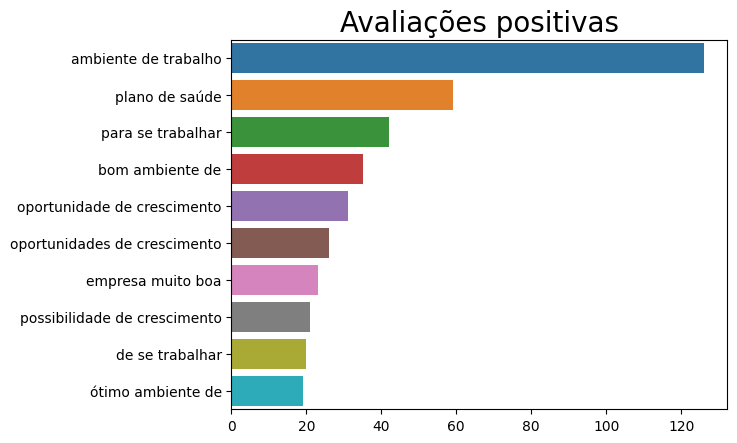

In [15]:
plot_top_ngrams_barchart(
    positive_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações positivas",
)

#### Negative N-Grams

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


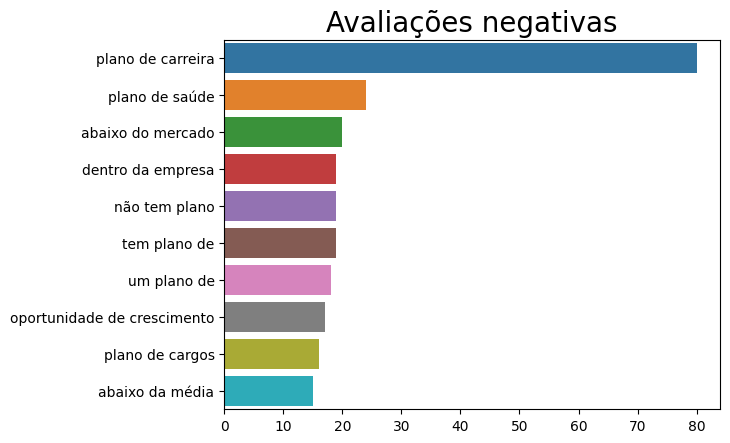

In [16]:
plot_top_ngrams_barchart(
    negative_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações negativas",
)

#### Neutral N-Grams

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


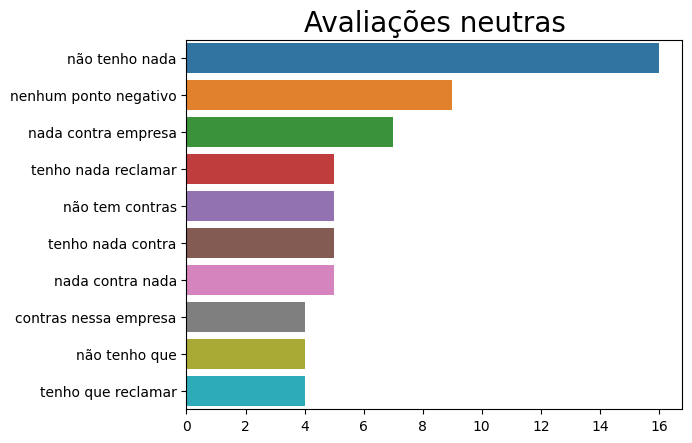

In [17]:
plot_top_ngrams_barchart(
    neutral_reviews_df["review_text"],
    n_grams=3,
    top=10,
    title="Avaliações neutras",
)

## WordCloud

In [18]:
def print_wordcloud(corpus, title=None):
    non_stopwords_corpus = []
    for word in corpus:
        word_lower = word.lower()
        if (
            word_lower not in stop_stopwords_portuguese
            and word_lower not in punctuation
        ):
            non_stopwords_corpus.append(word_lower)

    non_stopwords_corpus_str = " ".join(non_stopwords_corpus)

    wordcloud = WordCloud(
        background_color="white",
        random_state=RANDOM_SEED,
        max_words=150,
        width=1024,
        height=768,
    )

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis("off")

    plt.imshow(wordcloud.generate(str(non_stopwords_corpus_str)))
    plt.title(title, fontsize=20)
    plt.show()

#### Positive WordCloud

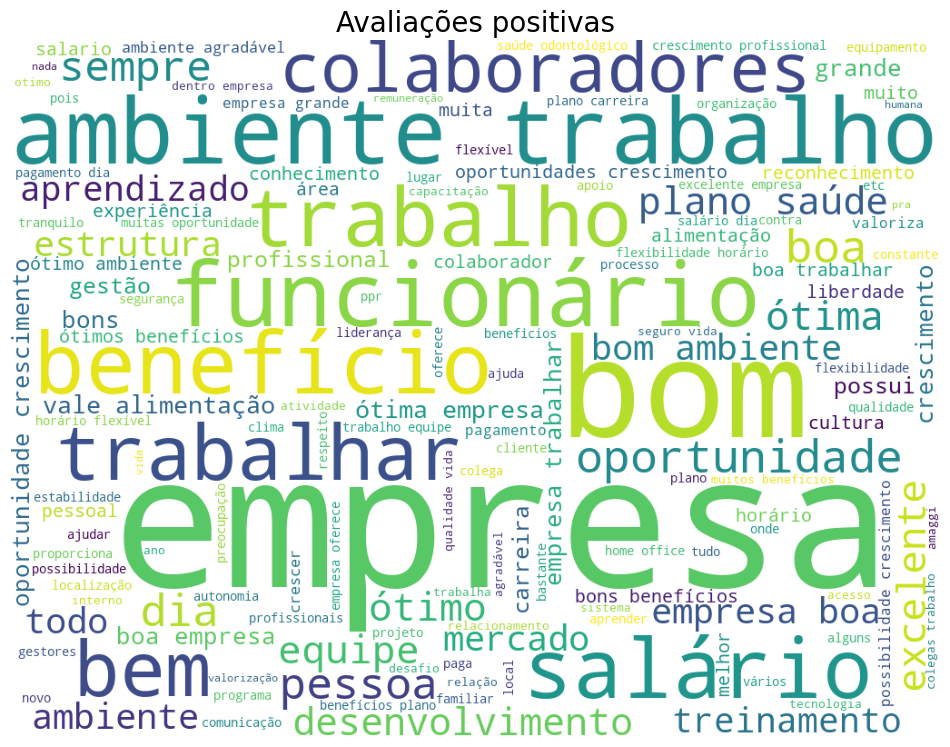

In [19]:
review_text = positive_reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

print_wordcloud(corpus, title="Avaliações positivas")

#### Negative WordCloud

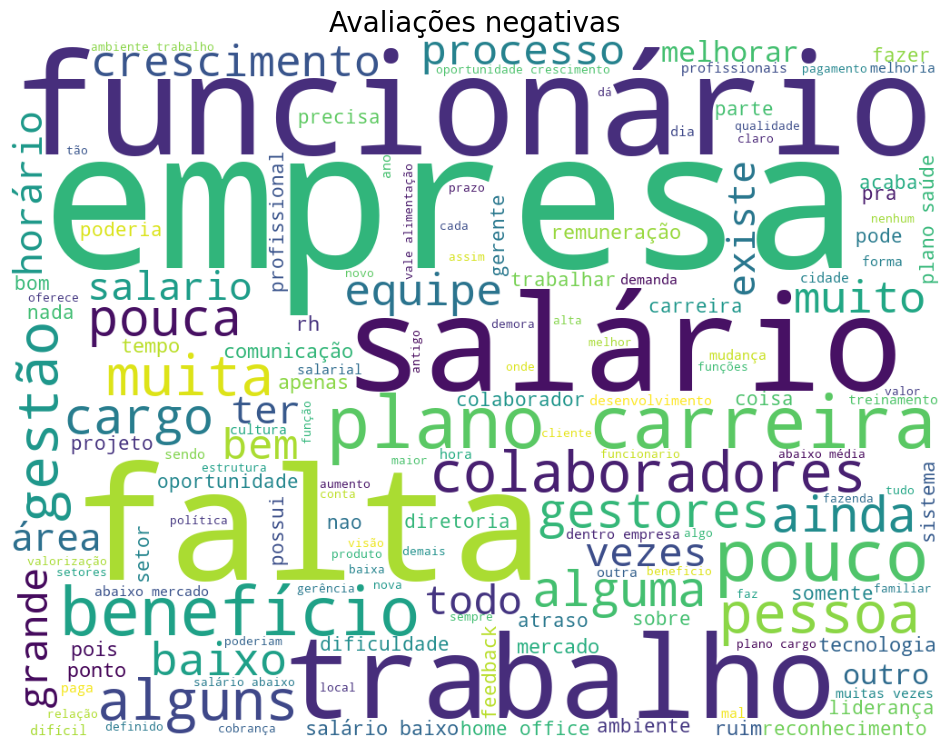

In [20]:
review_text = negative_reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

print_wordcloud(corpus, title="Avaliações negativas")

#### Neutral WordCloud

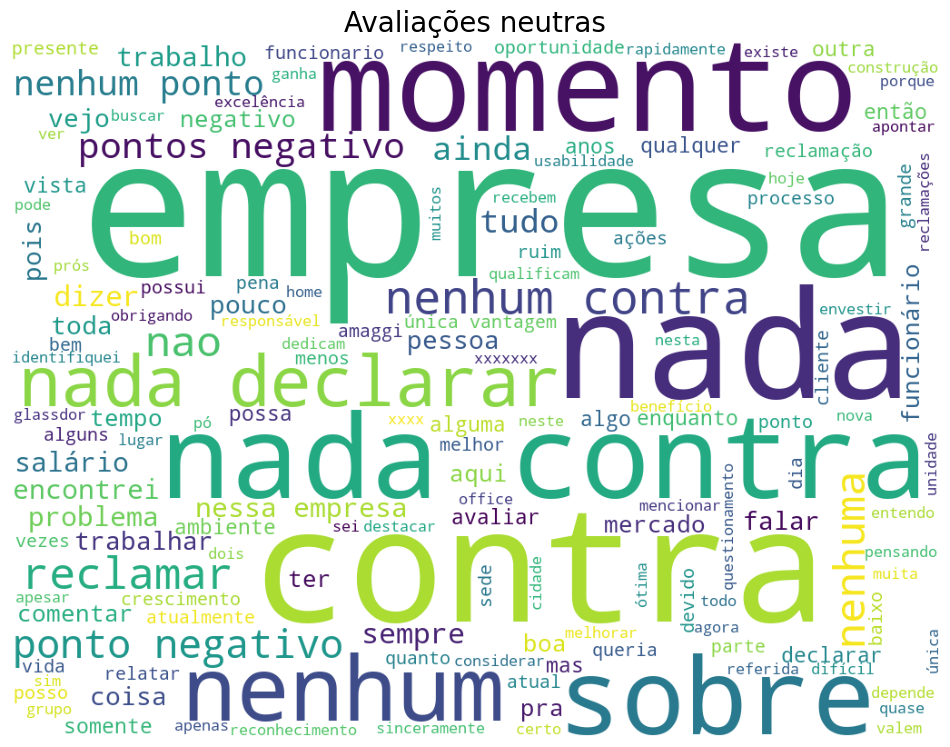

In [21]:
review_text = neutral_reviews_df["review_text"].str.split().values.tolist()
corpus = [word for i in review_text for word in i]

print_wordcloud(corpus, title="Avaliações neutras")

## Sentiment statistics

In [22]:
SENTIMENT_DICT = {0: "Neutral", 1: "Positive", 2: "Negative"}

### Predicted Sentiment Distribution

In [23]:
sentiment_counts = reviews_df["predicted_sentiment"].value_counts().reset_index()
sentiment_counts.columns = ["predicted_sentiment", "count"]

In [24]:
sentiment_counts.head()

,predicted_sentiment,count
0,1,1272
1,2,1066
2,0,228


In [25]:
sentiment_counts = sentiment_counts.sort_values(by="count", ascending=False)

In [26]:
sentiment_counts

,predicted_sentiment,count
0,1,1272
1,2,1066
2,0,228


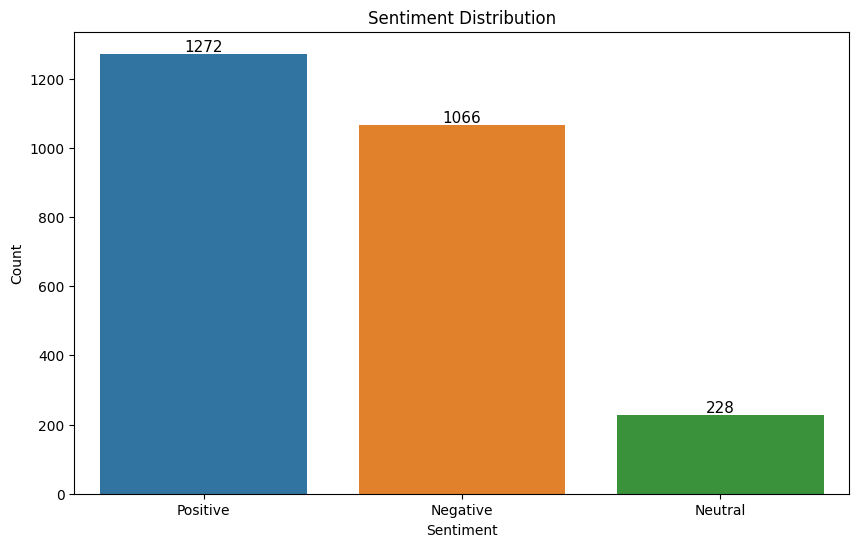

In [27]:
ax = plt.subplots(1, figsize=(10, 6))

ax = sns.barplot(
    data=sentiment_counts,
    x=sentiment_counts.index,
    y="count",
    palette=sns.color_palette(sns.color_palette(), n_colors=3),
)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=11,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.xlabel("Sentiment")
plt.ylabel("Count")

ax.set_xticklabels(
    [SENTIMENT_DICT[sentiment] for sentiment in sentiment_counts["predicted_sentiment"]]
)

plt.title("Sentiment Distribution")
plt.show()

### Predicted Sentiment by Company

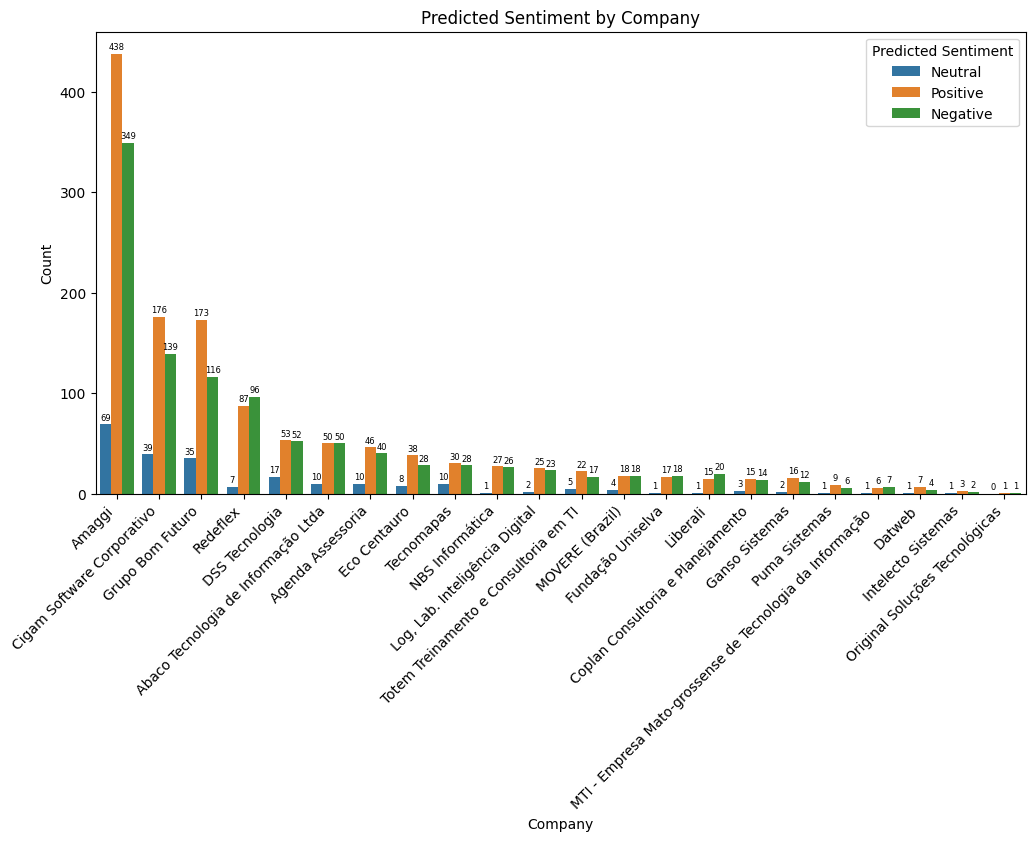

In [28]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=reviews_df,
    x="company",
    hue="predicted_sentiment",
    order=reviews_df["company"].value_counts().index,
)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.title("Predicted Sentiment by Company")
plt.xlabel("Company")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Predicted Sentiment", labels=SENTIMENT_DICT.values())
plt.show()

### Predicted Sentiment by Star Rating

In [29]:
warnings.filterwarnings("ignore", "use_inf_as_na")

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


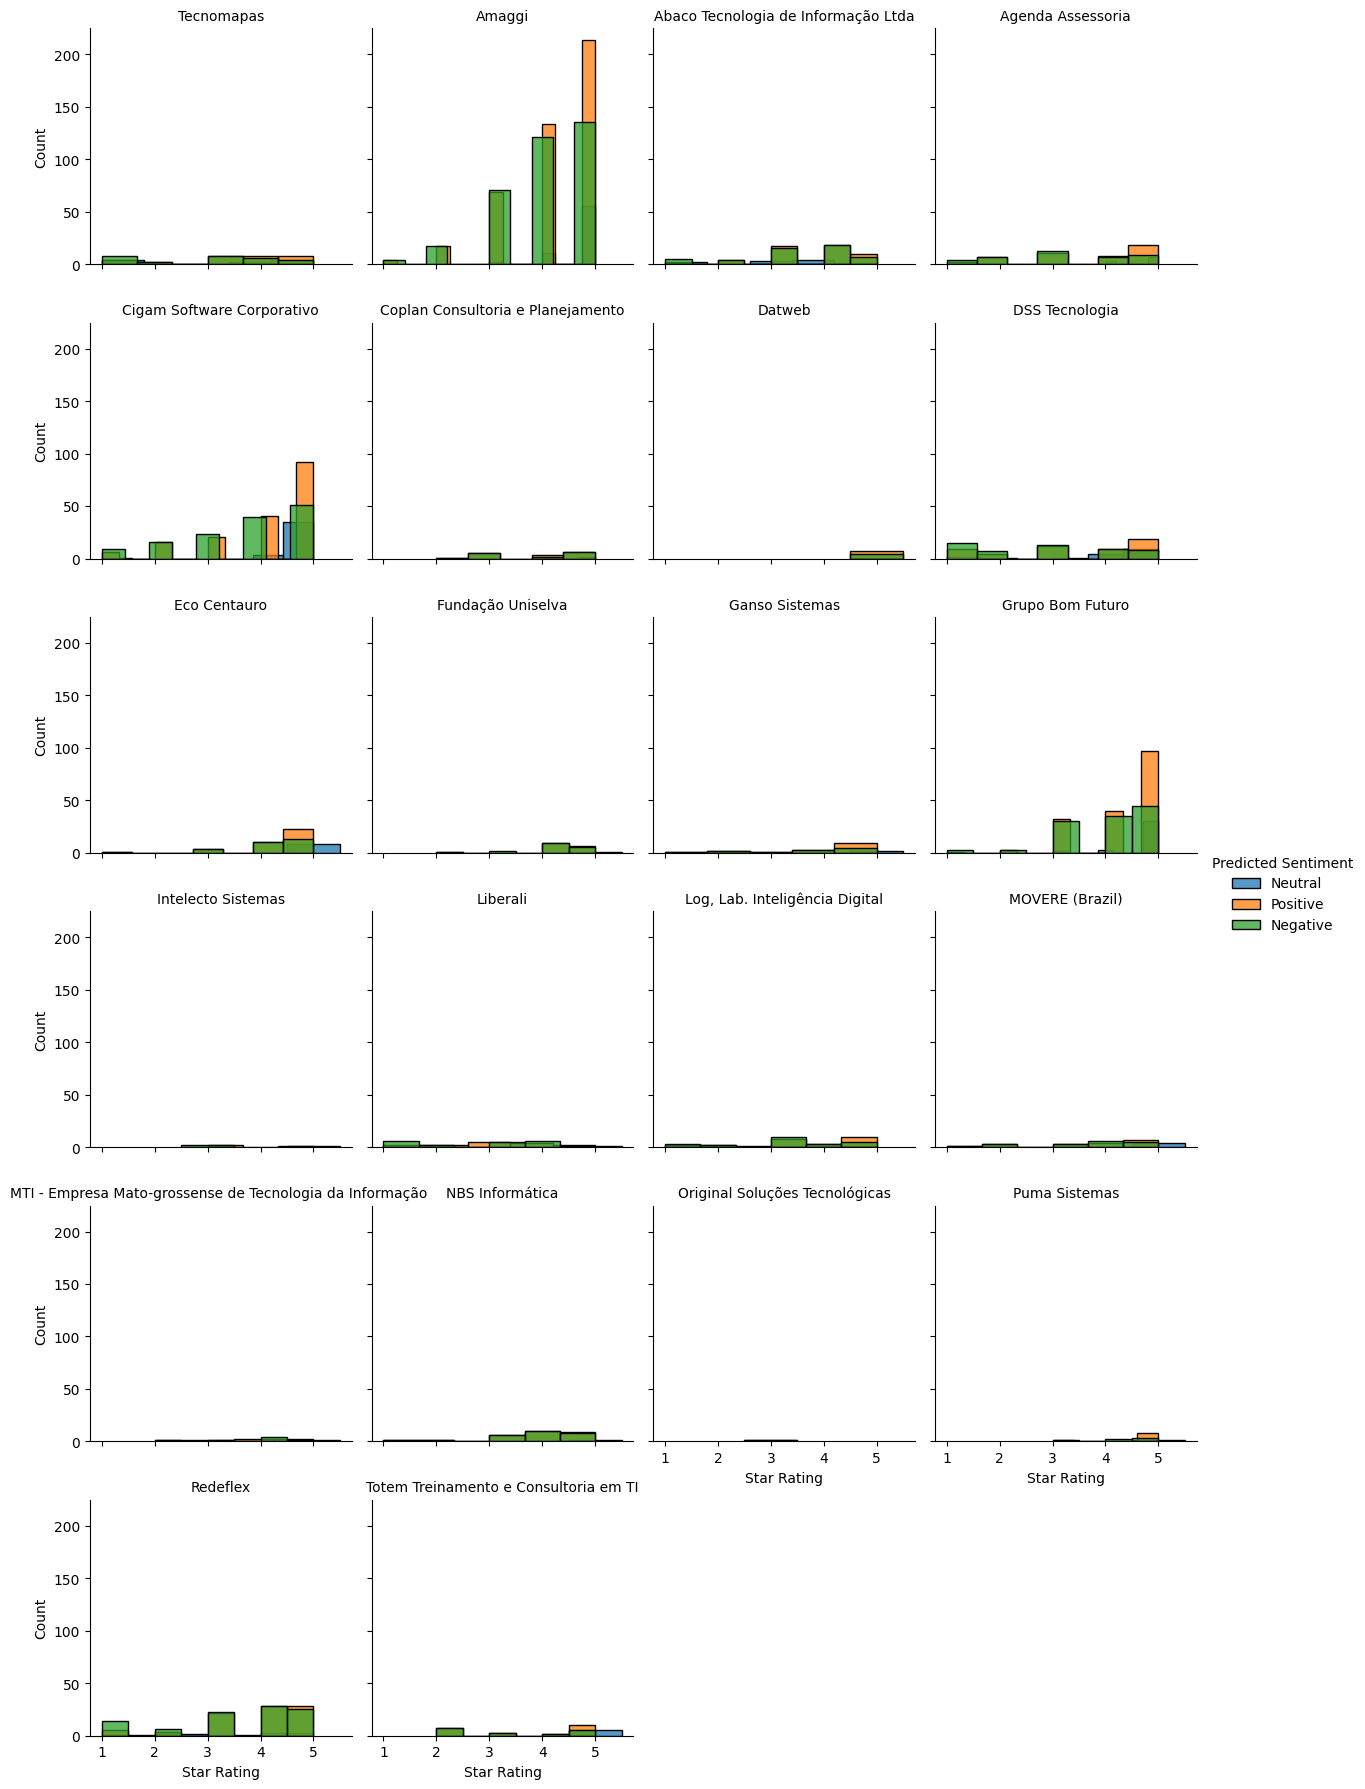

In [30]:
g = sns.FacetGrid(
    reviews_df,
    col="company",
    hue="predicted_sentiment",
    col_wrap=4,
)
g.map(sns.histplot, "star_rating")

g.set_titles("{col_name}")
g.set_axis_labels("Star Rating", "Count")
g.add_legend(
    title="Predicted Sentiment",
    labels=list(SENTIMENT_DICT.values()),
)

plt.show()

### Predicted Sentiment by Employee Role

In [31]:
desired_company = "Amaggi"
desired_sentiment = 0

In [32]:
reviews_df[reviews_df["company"] == desired_company][
    "predicted_sentiment"
].value_counts()

predicted_sentiment
1    438
2    349
0     69
Name: count, dtype: int64

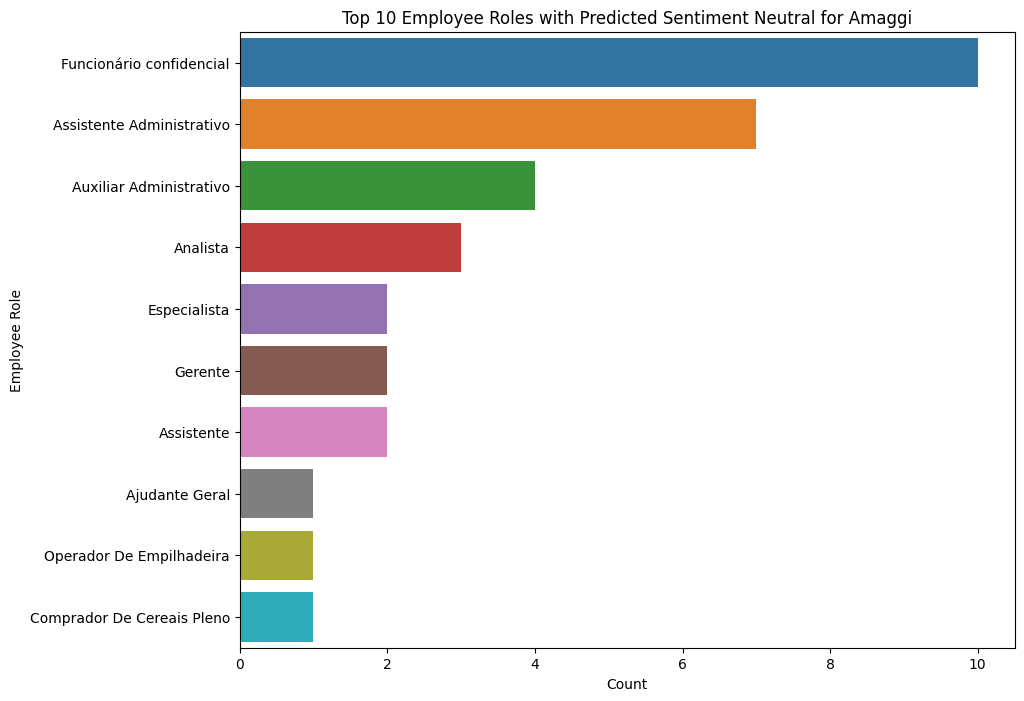

In [33]:
company_df = reviews_df[reviews_df["company"] == desired_company]
filtered_df = company_df[company_df["predicted_sentiment"] == desired_sentiment]
top_10_roles = filtered_df["employee_role"].value_counts().index[:10]
filtered_df = filtered_df[filtered_df["employee_role"].isin(top_10_roles)]

plt.figure(figsize=(10, 8))
sns.countplot(data=filtered_df, y="employee_role", order=top_10_roles)

plt.title(
    f"Top 10 Employee Roles with Predicted Sentiment {SENTIMENT_DICT[desired_sentiment]} for {desired_company}"
)
plt.xlabel("Count")
plt.ylabel("Employee Role")
plt.show()